In [1]:
import sys
sys.path.append('../')
import scipy.io
from utils.mat_to_tfrecord_analysis import formatSessionData
from pathlib import Path
import numpy as np
import os

session = 't18.2024.12.03'
blocks = [2,3,4,5,6]
trialsToRemove = []
dataDir = str(Path('../Data', 't18', session, 'brainToText'))
data = formatSessionData(
                      blocks,
                      trialsToRemove,
                      dataDir,
                      start_offset=-250,
                      end_offset=250,
                      channels_to_exclude=[],
                      channels_to_zero=[],
                      includeThreshCrossings=True,
                      includeSpikePower=False,
                      spikePowerMax=10000,
                      globalStd=True,
                      zscoreData=True,
                      bin_compression_factor=1)

inputFeatures = data['inputFeatures']
cues = data['transcriptions']
cues = np.array([cue.strip() for cue in cues])
all_cues, counts = np.unique(cues,return_counts=True)
arrays = {'All Motor Channels' : np.arange(0,384)}

RedisMat file for block 2: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_163758_(2).mat
RedisMat file for block 3: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_165120_(3).mat
RedisMat file for block 4: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_170328_(4).mat
RedisMat file for block 5: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_172055_(5).mat
RedisMat file for block 6: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_173328_(6).mat


In [2]:
mapping_right =  ['RIGHT PINKY - In to Palm',
           'RIGHT PINKY - Straight Downwards',
           'RIGHT PINKY - Extend Upwards',
           'RIGHT RING - In to Palm',
           'RIGHT RING - Straight Downwards',
           'RIGHT RING - Extend Upwards',
           'RIGHT MIDDLE - In to Palm',
           'RIGHT MIDDLE - Straight Downwards',
           'RIGHT MIDDLE - Extend Upwards',
           'RIGHT INDEX - In to Palm',
           'RIGHT INDEX - Straight Downwards',
           'RIGHT INDEX - Extend Upwards',
           'RIGHT THUMB - In to Palm',
           'RIGHT THUMB - Straight Downwards',           
           'RIGHT THUMB - Extend Upwards']

mapping_left = ['LEFT PINKY - In to Palm',
           'LEFT PINKY - Straight Downwards',           
           'LEFT PINKY - Extend Upwards',
           'LEFT RING - In to Palm',
           'LEFT RING - Straight Downwards',           
           'LEFT RING - Extend Upwards',
           'LEFT MIDDLE - In to Palm',
           'LEFT MIDDLE - Straight Downwards',           
           'LEFT MIDDLE - Extend Upwards',
           'LEFT INDEX - In to Palm',
           'LEFT INDEX - Straight Downwards',           
           'LEFT INDEX - Extend Upwards',
           'LEFT THUMB - In to Palm',
           'LEFT THUMB - Straight Downwards',
           'LEFT THUMB - Extend Upwards',]

In [5]:
gathered_trials_right = []
for i, k in enumerate(mapping_right):
    indices = np.array(np.argwhere(cues == k)).flatten()
    all_trials_this_phone = np.zeros((indices.shape[0],  inputFeatures[0].shape[0], inputFeatures[0].shape[-1]))    
    for j, trial in enumerate(indices):
        all_trials_this_phone[j,:inputFeatures[trial].shape[0] ,:] = np.nan_to_num(inputFeatures[trial][:750, :])
    gathered_trials_right.append(all_trials_this_phone)

gathered_trials_left = []
for i, k in enumerate(mapping_left):
    indices = np.array(np.argwhere(cues == k)).flatten()
    print(indices.shape)
    all_trials_this_phone = np.zeros((indices.shape[0],  inputFeatures[0].shape[0], inputFeatures[0].shape[-1]))    
    for j, trial in enumerate(indices):
        all_trials_this_phone[j,:inputFeatures[trial].shape[0] ,:] = np.nan_to_num(inputFeatures[trial][:750, :])
    gathered_trials_left.append(all_trials_this_phone)

(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(9,)
(10,)
(10,)
(10,)


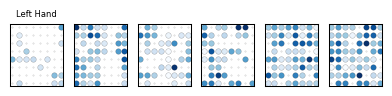

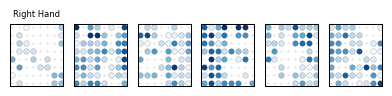

In [4]:
import scipy.stats
import matplotlib.pyplot as plt
from utils.analysisT18 import makeTuningHeatmapT18, heatmapPlotCirclesT18
range_to_apply = [250,350]
tuningR2_left_hand, tuningPVal_left_hand = makeTuningHeatmapT18(mapping_left, gathered_trials_left, range_to_apply)
tuningR2_right_hand, tuningPVal_right_hand = makeTuningHeatmapT18(mapping_right, gathered_trials_right, range_to_apply)
heatmapPlotCirclesT18(tuningR2_left_hand,tuningPVal_left_hand<0.0001,[0,0.7],['Left Hand'],'all')
plt.savefig('T18ArraysFVAFsleft.pdf')
plt.show()
heatmapPlotCirclesT18(tuningR2_right_hand,tuningPVal_right_hand<0.0001,[0,0.7], ['Right Hand'],'all')
plt.savefig('T18ArraysFVAFsright.pdf')
plt.show()

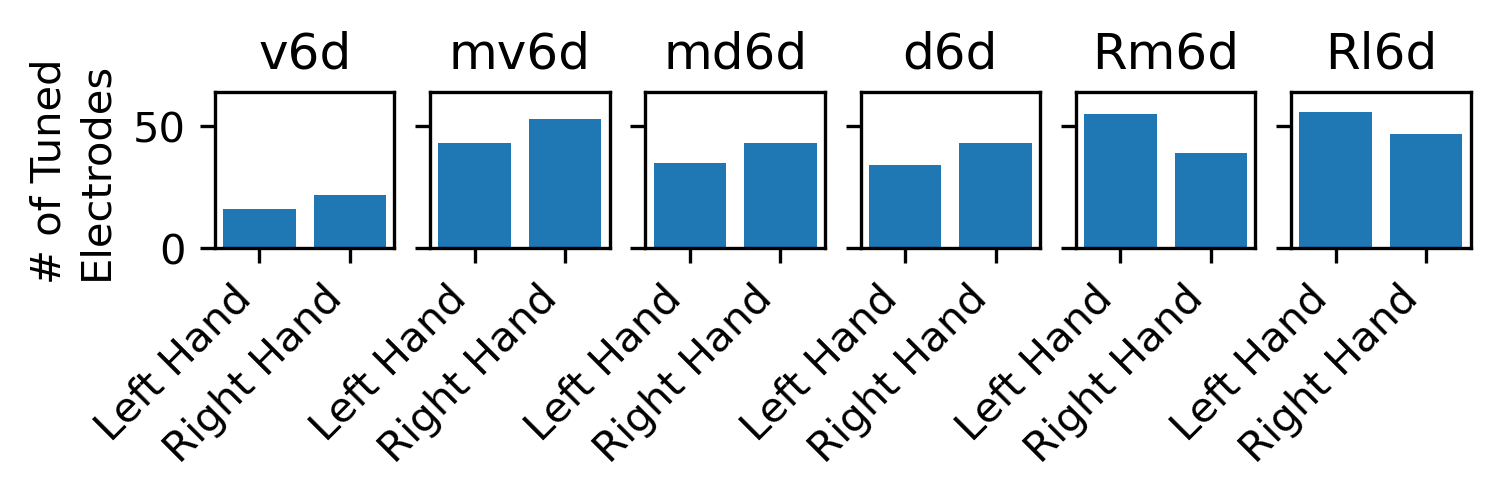

In [12]:
tuningPVal_all = np.concatenate([tuningPVal_left_hand, tuningPVal_right_hand], axis=1)
chanSets = [
               np.arange(64,128).astype(np.int32),
                np.arange(0,64).astype(np.int32), 
                np.arange(192,256).astype(np.int32),
               np.arange(128,192).astype(np.int32),
               np.arange(320,384).astype(np.int32),
               np.arange(256,320).astype(np.int32),
               ]

titles = ['v6d', 'mv6d', 'md6d', 'd6d', 'Rm6d', 'Rl6d']
plt.figure(dpi=300, figsize=(6*0.90, 0.75*0.90))
for setIdx in range(len(chanSets)):
    plt.subplot(1,6,setIdx+1)
    categories = np.sum(tuningPVal_all[chanSets[setIdx],:]<0.0001, axis=0)
    plt.bar(np.arange(0, len(categories)).astype(np.int32), categories)
    plt.ylim([0,64])
    plt.xticks(ticks=np.arange(0,2), labels=['Left Hand', 'Right Hand'], rotation=45, ha="right")
    if setIdx>0:
        plt.yticks(ticks=[0, 50],labels=[])
    if setIdx==0:
        plt.ylabel('# of Tuned\nElectrodes')
    plt.title(titles[setIdx])
plt.savefig('T18NumTunedChannels.pdf')
plt.show()